# Import Modules

In [24]:
# %conda install wordcloud

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::seaborn-base==0.11.1=pyhd8ed1ab_1
  - conda-forge/noarch::nbclassic==0.2.6=pyhd8ed1ab_0
  - conda-forge/linux-64::numexpr==2.7.2=py36h284efc9_0
  - conda-forge/linux-64::statsmodels==0.12.2=py36h92226af_0
  - conda-forge/linux-64::blaze==0.11.3=py36_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - conda-forge/linux-64::scipy==1.5.3=py36h9e8f40b_0
  - conda-forge/noarch::jupyterlab==3.0.9=pyhd8ed1ab_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/noarch::jupyterlab_server==2.3.0=pyhd8ed1ab_0
  - conda-forge/linux-64::pytables==3.6.1=py36hb7ec5aa_3
  - conda-forge/linux-64::pandas==1.1.5=py36h284efc9_0
  - conda-forge/linux-64::astropy==4.1=py36ha112f06_2
  - conda-forge/noarch::pyls-black==0.4.6=pyh9f0ad1d_0
  - conda-forge/linux-64::scikit-image==0.16.2=py36hb

In [25]:
# data tools
import os
import re
import json 
import warnings 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
from subprocess import check_output

# nltk and sklearn
import nltk
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# tensorflow and keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Get the dataset (Amazon Video Game Reviews)

In [27]:
# !curl https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz -o games.tsv
# !gzip -d games.tsv

In [28]:
games = pd.read_csv('games.tsv', sep='\t', error_bad_lines=False)

b'Skipping line 20630: expected 15 fields, saw 22\nSkipping line 28172: expected 15 fields, saw 22\nSkipping line 54791: expected 15 fields, saw 22\n'
b'Skipping line 75419: expected 15 fields, saw 22\nSkipping line 104832: expected 15 fields, saw 22\n'
b'Skipping line 138464: expected 15 fields, saw 22\nSkipping line 194849: expected 15 fields, saw 22\n'
b'Skipping line 201568: expected 15 fields, saw 22\nSkipping line 242567: expected 15 fields, saw 22\n'
b'Skipping line 493585: expected 15 fields, saw 22\nSkipping line 502478: expected 15 fields, saw 22\n'
b'Skipping line 660750: expected 15 fields, saw 22\n'


In [29]:
games.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

In [30]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780268 entries, 0 to 1780267
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   marketplace        object
 1   customer_id        int64 
 2   review_id          object
 3   product_id         object
 4   product_parent     int64 
 5   product_title      object
 6   product_category   object
 7   star_rating        int64 
 8   helpful_votes      int64 
 9   total_votes        int64 
 10  vine               object
 11  verified_purchase  object
 12  review_headline    object
 13  review_body        object
 14  review_date        object
dtypes: int64(5), object(10)
memory usage: 203.7+ MB


In [31]:
games.duplicated().sum()

0

In [32]:
games.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


In [33]:
len(games)

1780268

In [34]:
games.iloc[0:20].review_headline

0     an amazing joystick. I especially love that yo...
1     Definitely a silent mouse... Not a single clic...
2                                              One Star
3                             good, but could be bettee
4                                     Great but flawed.
5                                              One Star
6                                                A Must
7                                            Five Stars
8                                            Five Stars
9                                            Four Stars
10                                           Five Stars
11                                  Game will get stuck
12    We have tried it with kids ages 4-7 and none o...
13                                           Four Stars
14    Now i have to buy a better one. Sorry guys but...
15                                           Five Stars
16                                           Five Stars
17                                           Fiv

In [35]:
games.iloc[0:5].review_body

0    Used this for Elite Dangerous on my mac, an am...
1    Loved it,  I didn't even realise it was a gami...
2       poor quality work and not as it is advertised.
3    nice, but tend to slip away from stick in inte...
4    Great amiibo, great for collecting. Quality ma...
Name: review_body, dtype: object

In [36]:
games.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


In [37]:
#games.overall.value_counts()

In [38]:
games.isna().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline      28
review_body          59
review_date          27
dtype: int64

In [39]:
#games[games.reviewText.isna()==True].overall.value_counts()

There are a very small number of reviews with no text, they make up a very small percentage of the overall reiews and don't look particularly biased, so they should be safe to drop

In [40]:
#games.dropna(subset=['reviewText'], inplace=True)

In [41]:
games.isna().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline      28
review_body          59
review_date          27
dtype: int64

Missing values in the other columns should not be as big of an issue, as they are not as integral to our analysis

Preprocessing and Visualization

In [42]:
def preprocess(text):
    words = text.split(' ')
           
    lem = nltk.stem.WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in words]
    
    stopwords = nltk.corpus.stopwords.words('english')
    words = [word for word in words if word not in stopwords]
   
    return ' '.join(words)

In [43]:
# games['text_clean'] = games.reviewText.apply(preprocess)
games.sample(10)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
360004,US,39266265,R3DQV36M9H8RLW,B00BU3ZLJQ,860676261,Minecraft - Xbox 360,Video Games,5,1,1,N,Y,Five Stars,Great game! bought it for my kids and they lov...,2014-12-17
938972,US,45233233,R3S6XQPKR4CBYD,B003E86NL0,458714774,Wii Fit Rechargeable Battery Pack for Balance ...,Video Games,5,0,0,N,Y,Great addition to your Wii accessory,"The Battery pack works very well, I have used ...",2013-03-09
85348,US,35199686,RW0HX0DUGPHQX,B002SD94AY,652294944,Gen Soft Rubber Jelly Silicone Skin Cover Case...,Video Games,5,0,0,N,Y,Five Stars,A+++,2015-06-17
1574759,US,22754862,R3JH1IB4KW0M7N,B00002ST7F,591102544,Sonic the Hedgehog 2,Video Games,4,0,0,N,N,Kiddy Game,This is more of a kiddy game because of its gr...,2005-12-06
36312,US,16459928,R1GH9L2LTZJD2T,B00KVXB5YQ,879556367,Grand Theft Auto V,Video Games,5,0,0,N,Y,Five Stars,I selected the 3 day shipping adn the game cam...,2015-07-30
1705166,US,50649070,R3PCH1JDPA2WPO,B00005KHYO,782578883,18 Wheeler: American Pro Trucker,Video Games,2,5,7,N,N,Not Impressed!,18 Wheeler is only a very average game at best...,2002-03-27
60101,US,45803980,R3F1EKQGNL1GEI,B000066TS3,745951041,Onimusha 2: Samurai's Destiny,Video Games,5,0,0,N,Y,Happy,The game I got was good. I am pleased that it ...,2015-07-10
1279461,US,52540202,R1IW7TDWVZR4GB,B0026AH6JA,343172847,The Sagara Family Bishouju PC Game,Video Games,5,11,11,N,Y,Great Game,I just finished my first play through and whil...,2011-01-06
769161,US,15233403,ROY1BXT49YCSK,B00EADTVL2,386985141,Microsoft licensed Energizer 2X Charging System,Video Games,5,4,6,N,Y,Convenient,Easy to set up. Completely charged the contro...,2013-11-16
1227537,US,30173594,R51PTAKIWNU4S,B003ZCH7DI,901237537,Kirby's Epic Yarn,Video Games,3,0,2,N,N,No Depth in character,"While the game is fun and good-spirited, the c...",2011-06-24


In [44]:
# full_text = ' '.join(games.text_clean)
# wordcloud = WordCloud().generate(full_text)

# plt.rcParams["figure.figsize"] = (20,15)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

AttributeError: 'DataFrame' object has no attribute 'text_clean'

In [ ]:
# full_text = ' '.join(games.text_clean[games.overall==5])
# wordcloud = WordCloud().generate(full_text)

# plt.rcParams["figure.figsize"] = (20,15)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

In [ ]:
# full_text = ' '.join(games.text_clean[games.overall==1])
# wordcloud = WordCloud().generate(full_text)

# plt.rcParams["figure.figsize"] = (20,15)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

In [45]:
games = games[['review_body','star_rating']]

In [46]:
games

,review_body,star_rating
0,"Used this for Elite Dangerous on my mac, an am...",5
1,"Loved it, I didn't even realise it was a gami...",5
2,poor quality work and not as it is advertised.,1
3,"nice, but tend to slip away from stick in inte...",3
4,"Great amiibo, great for collecting. Quality ma...",4
...,...,...
1780263,I don't think it is necessary for me to wax po...,5
1780264,If I could rate higher than a ten I would. Thi...,5
1780265,Fewer than 1 in 3 modern Windows computers are...,1
1780266,Unfortunately Riven is available only to those...,1


In [47]:
row_select_1 = games['star_rating'] < 3
row_select_2 = games['star_rating'] == 3
games['sentiment'] = pd.Series(['Positive']*len(games.index))
games.loc[row_select_1,'sentiment'] = 'Negative'
games.loc[row_select_2,'sentiment'] = 'Neutral'

In [48]:
games = games[['review_body','sentiment']]
games.columns = ['text', 'sentiment']

In [49]:
games

,text,sentiment
0,"Used this for Elite Dangerous on my mac, an am...",Positive
1,"Loved it, I didn't even realise it was a gami...",Positive
2,poor quality work and not as it is advertised.,Negative
3,"nice, but tend to slip away from stick in inte...",Neutral
4,"Great amiibo, great for collecting. Quality ma...",Positive
...,...,...
1780263,I don't think it is necessary for me to wax po...,Positive
1780264,If I could rate higher than a ten I would. Thi...,Positive
1780265,Fewer than 1 in 3 modern Windows computers are...,Negative
1780266,Unfortunately Riven is available only to those...,Negative


In [50]:
# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 2

In [51]:
games = games[games.sentiment != "Neutral"]
games['text'] = games['text'].apply(lambda x: str(x).lower())
games['text'] = games['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(games[ games['sentiment'] == 'Positive'].size)
print(games[ games['sentiment'] == 'Negative'].size)

for idx,row in games.iterrows():
    row[0] = row[0].replace('rt',' ')
    
tokenizer = Tokenizer(nb_words = max_features, split=' ')
tokenizer.fit_on_texts(games['text'].values)
X = tokenizer.texts_to_sequences(games['text'].values)
X = pad_sequences(X, maxlen = maxlen)

2681254
572380


In [52]:
Y = pd.get_dummies(games['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1301453, 100) (1301453, 2)
(325364, 100) (325364, 2)


In [53]:
print('Build model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          2560000   
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 70)                37800     
_________________________________________________________________
dense (Dense)                (None, 2)                 142       
Total params: 2,638,966
Trainable params: 2,638,966
Non-trainable params: 0
_______________________________

In [54]:
print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,shuffle=True, validation_data=(X_test, Y_test))

Train...
Epoch 1/2
43382/43382 [==============================] - 681s 16ms/step - loss: 0.1475 - accuracy: 0.9428 - val_loss: 0.1290 - val_accuracy: 0.9507
Epoch 2/2
43382/43382 [==============================] - 679s 16ms/step - loss: 0.1205 - accuracy: 0.9546 - val_loss: 0.1267 - val_accuracy: 0.9515


In [55]:
yhat = model.predict(X_test, verbose = 2, batch_size = batch_size)
from sklearn import metrics
print(metrics.classification_report(Y_test[:,1], np.round(yhat[:,1]) ,target_names = ["negative", "positive"]))

10846/10846 - 25s
              precision    recall  f1-score   support

    negative       0.85      0.88      0.86     57004
    positive       0.97      0.97      0.97    268360

    accuracy                           0.95    325364
   macro avg       0.91      0.92      0.92    325364
weighted avg       0.95      0.95      0.95    325364



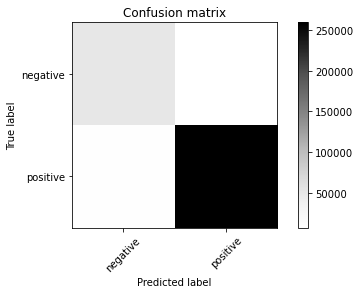

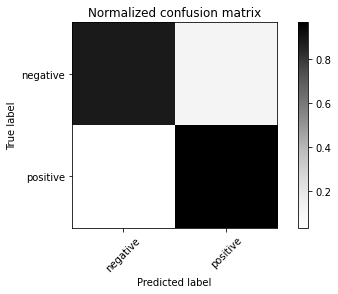

In [56]:
score = ['negative', 'positive']

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(score)))
    plt.xticks(tick_marks, score, rotation=45)
    plt.yticks(tick_marks, score)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(Y_test[:,1], np.round(yhat[:,1]))
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [57]:
# serialize model to JSON
model_json = model.to_json()
with open("model_conv_lstm.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_conv_lstm.h5")

In [58]:
score = ['negative', 'positive']

# Compute confusion matrix
cm = confusion_matrix(Y_test[:,1], np.round(yhat[:,1]))
np.set_printoptions(precision=2)

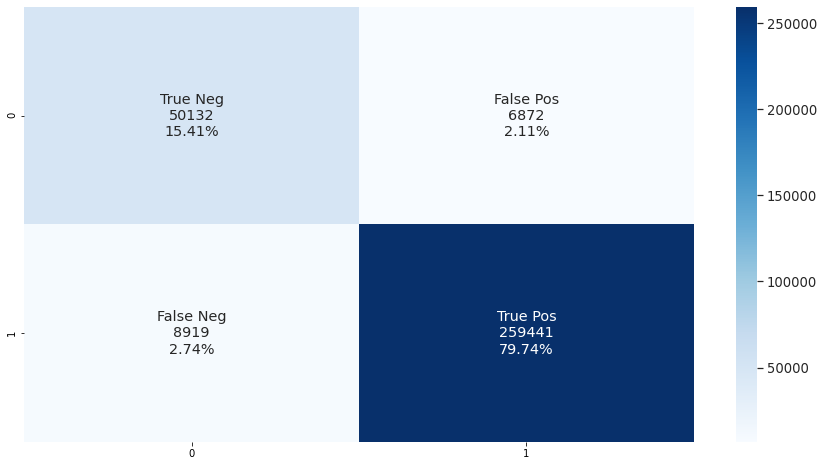

In [59]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.subplots(figsize=(15,8))
sns.set(font_scale=1.2)
conf_plot = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

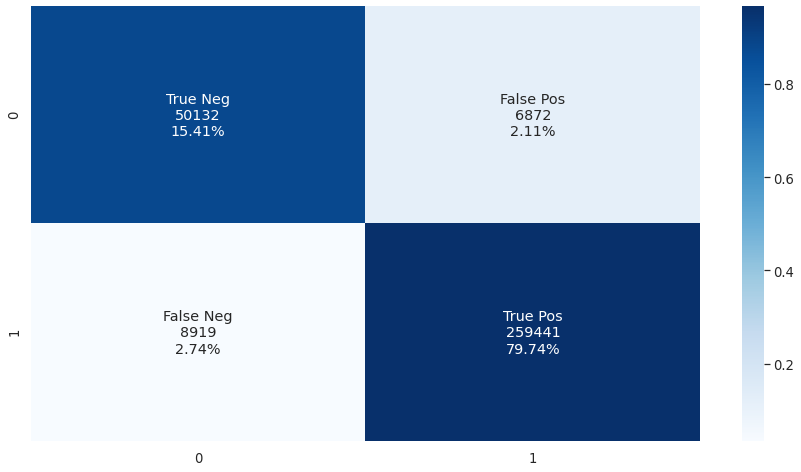

In [60]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplots(figsize=(15,8))
sns.set(font_scale=1.2)
conf_plot_norm = sns.heatmap(cm_normalized, annot=labels, fmt='', cmap='Blues')

.

### Citation For data:
    
Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019